## Species

### Prey
Table Coral                     - $\rho_1(t)$ 

Branch Coral                    - $\rho_2(t)$

### Predator
Crown of Thorns Starfish (CoT)  - $\beta(t)$ 

## Assumptions

- CoT only consumes two types of coral, Table and Branch
- CoT consumes Branch coral at a faster rate than Table coral, b>a
- Both corals grow independent of each other
- Prey will grow in the absense of predators
- Predator will encounter prey based on principles of mass action
- The effect of environmental factors, others predators, etc. is ignored
- CoT populations are contained to the Northern section of the reef

## Predator Prey System
\begin{align}
\frac{\partial \rho_1}{\partial t} &= P_1\rho_1 - a\rho_1\beta \\
\frac{\partial \rho_2}{\partial t} &= P_2\rho_2 - b\rho_2\beta \\
\frac{\partial \beta}{\partial t} &= (a\rho_1+b\rho_2)\beta - d\beta
\end{align}

In [45]:
from scipy import *
import numpy as np
from scipy.integrate import odeint
import scipy.linalg as la
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib notebook

In [35]:
time = r_[0:136:1000j]

In [32]:
def dxdt_normal(x,t,
                a=0.13,      #CoT cosumption rate of Table coral
                b=0.87,      #CoT consumption rate of Branch coral
                d=1,         #CoT death rate
                P1=0.1,      #Table coral growth rate (in/yr)
                P2=0.8       #Branch coral growth rate (in/yr)
               ):
    '''Lotka-Volterra predator prey system.'''
    d1 = P1*x[0]-a*x[0]*x[2]
    d2 = P2*x[1]-b*x[1]*x[2]
    d3 = (a*x[0]+b*x[1])*x[2]-d*x[2]
    return(d1, d2, d3)

In [33]:
def dxdt_harvest(x,t,
                a=0.13,      #CoT cosumption rate of Table coral
                b=0.87,      #CoT consumption rate of Branch coral
                P1=0.1,      #Table coral growth rate (in/yr)
                P2=0.8       #Branch coral growth rate (in/yr)
               ):
    '''Lotka-Volterra predator prey system. All terms remain the same,
    but harvesting of the starfish by humans has been included as a
    factor d = CoT death rate'''
    d1 = P1*x[0]-a*x[0]*x[2]
    d2 = P2*x[1]-b*x[1]*x[2]
    d = (pi/2+arctan(x[2]-10))*20/pi
    d3 = (a*x[0]+b*x[1])*x[2]-d*x[2]
    return(d1, d2, d3)

In [34]:
x = odeint(dxdt_normal,[4,8,5],time)

<IPython.core.display.Javascript object>


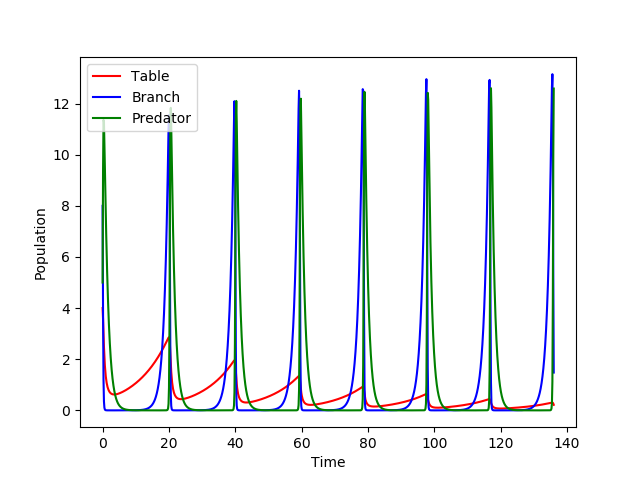

In [35]:
plt.figure()
plt.plot(time,x[:,0],'r')
plt.plot(time,x[:,1],'b')
plt.plot(time,x[:,2],'g')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend(('Table','Branch','Predator'));

In [7]:
y = odeint(dxdt_harvest,[4,8,5],time)

<IPython.core.display.Javascript object>


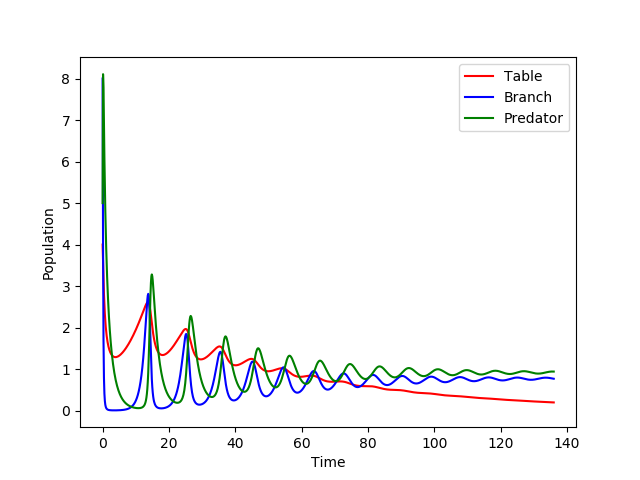

In [36]:
plt.figure()
plt.plot(time,y[:,0],'r')
plt.plot(time,y[:,1],'b')
plt.plot(time,y[:,2],'g')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend(('Table','Branch','Predator'));

## Spores Diffusion

\begin{align*}
\frac{d TableCoral}{dt} &= a(TableCoral) - b(TableCoral) (Starfish)\\
\frac{d BranchCoral}{dt} &= c(BranchCoral) - d(BranchCoral)(Starfish)\\
\frac{d Spores}{dt} &= e(Starfish) - Spores +\kappa \nabla^2 Spores\\
\frac{d Starfish}{dt} &= f[b(TableCoral) + d(BranchCoral)](Spores) - g(Starfish)\\
\end{align*}
#### Here we assume:
- Table Coral and Branch Coral grow indepently of eachother, a,c > 0
- Coral does not diffuse or grow into new places
- Only Starfish can eat Coral, b,d>0
- Any Starfish can produce Spores, and a lot of them e >1
- Spores are can diffuse, but Starfish cannot
- Only a small fraction of spores that interact with Coral can become starfish, 0<f<1
- Starfish die off at rate, 0<g<1
    - $g$ = constant without harvesting
    - $g$ = $(\frac{\pi}{2}+\arctan(Starfish-10))\frac{20}{\pi}$ with harvesting


In [210]:
L = 1
N = 40
x = linspace(0,1,N)
h = L/(N-1)

# Build a Laplacian differentiation matrix.
D2 = (diag(-2*ones(N),0)+diag(ones(N-1),-1)+diag(ones(N-1),1))
D2[0,0]=-1 ## must set boundary conditions
D2[0,1]=1 
D2[-1,-1]=-1
D2[-1,-2]=1
D2 = D2/h**2


def dxdt(x,t,
            a     = 0.10,     #Table coral growth rate (in/yr)
            b     = 0.13,     #CoT cosumption rate of Table coral
            c     = 0.87,     #Branch coral growth rate (in/yr)
            d     = 0.80,     #CoT consumption rate of Branch coral
            e     = 10.,      #Spore production per star
            f     = 0.01,     #Survival ratio of spores to adult stars
            g     = 0.10,     #Death rate of stars without coral to consume
            kappa = 0.01,     #Diffusion rate of spores
            harv  = 1.00      #Binary, 1 if harvesting is present, 0 if not
        ):
    '''Lotka-Volterra predator prey system with diffusion.
    Assume
    - Coral does not diffuse, nor do stars, relative to the size of the reef
    - Only spores stars diffuse across the reef at rate kappa
    - Only stars eat coral, babies do not consume anything
    - Table coral grows slower than branching:                        a < c
    - Table is eaten substantially slower than branching:             b < d
    - Stars live for a certain amount of time but die off gradaully, are eaten by predators, etc:  g
    - At any given time a certain amount of stars produce offspring:  e
    - At any given time a certain amount of babies reach adulthood:   f
    - There are initiatives by humans to remove Stars, but only in the case of outbreaks, FIX THIS
    '''
    table = x[:len(x)//4]
    branch = x[len(x)//4:2*len(x)//4]
    spores = x[2*len(x)//4:3*len(x)//4]
    stars = x[3*len(x)//4:]
    if(harv == 1): 
        g = (pi/2+arctan(stars-10))*20/pi
    d_table_dt  =  a*table - b*table*stars
    d_branch_dt =  c*branch - d*branch*stars
    d_spores_dt =  e*stars - spores + kappa*(D2.dot(spores))
    d_stars_dt  =  f*(b*table + d*branch)*spores - g*stars
    out = reshape(array([d_table_dt,d_branch_dt,d_spores_dt,d_stars_dt]),(len(x),))
    return(out)

In [211]:
time      = r_[0:180:1000j]
tableIC   = (1+0.5*cos(pi*x*16))+10
branchIC  = (1-0.2*cos(pi*x*8))+9
sporesIC  = 2*(1-cos(pi*x)) + 10
starsIC   = zeros(N)
starsIC[:5] = 5

IC = np.reshape(np.vstack((tableIC,branchIC,sporesIC,starsIC)),(4*N,))

In [212]:
u = odeint(dxdt,IC,time)

<IPython.core.display.Javascript object>


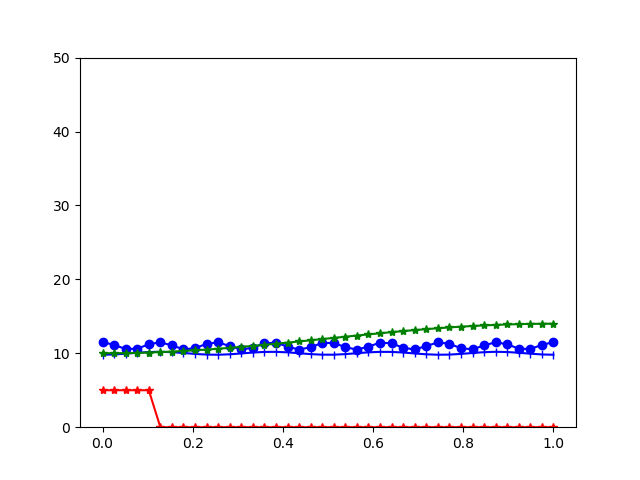

(0, 50)

In [188]:
## Plot the Initial Conditions
fig, ax = plt.subplots()
line1, = ax.plot(x,u[0,:N],'bo-')
line2, = ax.plot(x,u[0,N:2*N],'b|-')
line3, = ax.plot(x,u[0,2*N:3*N],'g*-')
line4, = ax.plot(x,u[0,3*N:],'r*-')
plt.ylim((0,50))

<IPython.core.display.Javascript object>


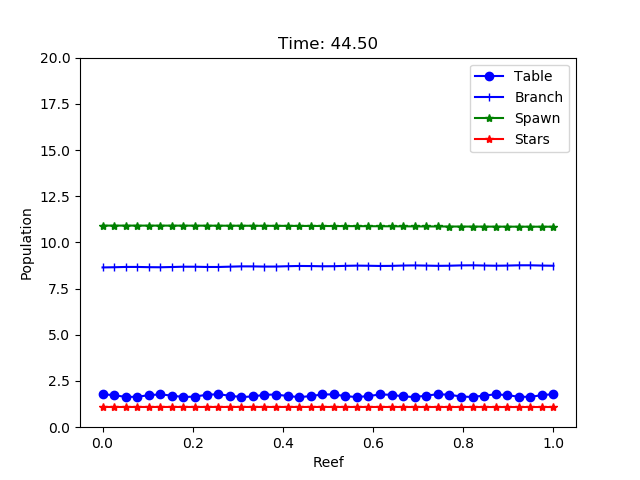

In [213]:
fig, ax = plt.subplots()
line1, = ax.plot(x,u[0,:N],'bo-')
line2, = ax.plot(x,u[0,N:2*N],'b|-')
line3, = ax.plot(x,u[0,2*N:3*N],'g*-')
line4, = ax.plot(x,u[0,3*N:],'r*-')
plt.ylim((0,20))
plt.legend(('Table','Branch','Spawn','Stars'))
plt.xlabel('Reef')
plt.ylabel('Population')

def animate(k):
    line1.set_ydata(u[k,:N])
    line2.set_ydata(u[k,N:2*N])
    line3.set_ydata(u[k,2*N:3*N])
    line4.set_ydata(u[k,3*N:])
    plt.title('Time: {0:5.2f}'.format(time[k]))
    return (line1,line2,line3,line4,)

ani = animation.FuncAnimation(fig, animate, frames=arange(1, 1000), 
                              interval=100, blit=True)

plt.show()

<IPython.core.display.Javascript object>


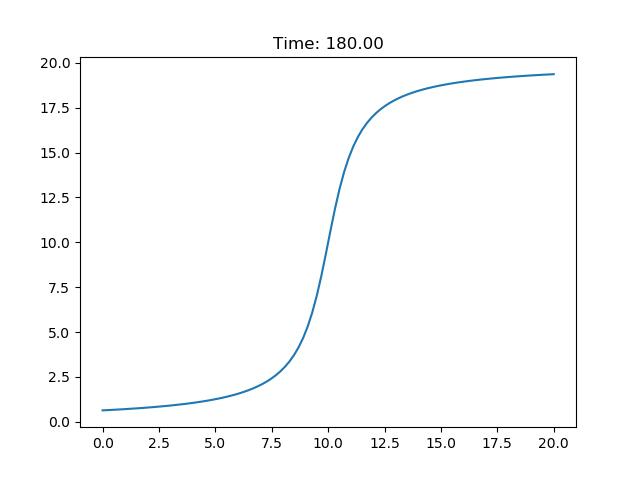

In [14]:
x = r_[0:20:100j]
amp=20
PopCrit = 10
plt.figure()
plt.plot(x,(pi/2+arctan(x-PopCrit))*amp/pi)
plt.show()